# Image Ingestion, Indexing & Annotation

Pipeline:
1. **Ingest** — Upload local images to S3 (source of truth)
2. **Preview** — Visualize preprocessing transforms and crop strips
3. **Index** — Preprocess, crop, CLIP embed, and upsert to Qdrant (visual only)
4. **Annotate** — Label crops with text + topic tags, update Qdrant with text embeddings

Run sections in order. Re-running is safe — all operations are idempotent.

## 1. Setup

In [5]:
import base64
import io
from datetime import datetime, timezone
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image

from rag.client import get_client
from rag.config import settings
from rag.embeddings.bge_embedder import embed_dense, embed_sparse
from rag.schema import ensure_collection_exists
from ocr_agent.tools import _apply_high_contrast

INPUT_DIR = Path("../data/input")

client = get_client()
ensure_collection_exists(client)

# Show what's available locally
local_images = sorted(f.name for f in INPUT_DIR.iterdir() if f.suffix.lower() in (".jpg", ".jpeg", ".png"))
print(f"Connected to Qdrant.")
print(f"Local images ({len(local_images)}): {local_images}")

2026-02-18 21:06:59.697 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.


Connected to Qdrant.
Local images (2): ['IMG_4737.jpeg', 'test_notes.jpg']


## 2. Ingest — Upload images to S3

Upload local images from `data/input/` to S3. Skips files that already exist in the bucket.

In [2]:
from rag.storage.s3 import upload_image, list_images, sync_all

# Show what's already in S3
existing_keys = list_images()
existing_names = {Path(k).name for k in existing_keys}
print(f"Already in S3: {len(existing_keys)} images")

# Upload new local images
uploaded = 0
for img_path in INPUT_DIR.iterdir():
    if img_path.suffix.lower() not in (".jpg", ".jpeg", ".png"):
        continue
    if img_path.name in existing_names:
        print(f"  [skip] {img_path.name} — already in S3")
        continue
    key = upload_image(img_path)
    uploaded += 1
    print(f"  [ok] {img_path.name} → {key}")

print(f"\nUploaded {uploaded} new images. Total in S3: {len(existing_keys) + uploaded}")

2026-02-18 21:01:10.015 | INFO     | rag.storage.s3:list_images:118 - Found 18 images in s3://handwritten-ocr/


Already in S3: 18 images
  [skip] IMG_4737.jpeg — already in S3
  [skip] test_notes.jpg — already in S3

Uploaded 0 new images. Total in S3: 18


## 3. Preview — Preprocessing & Crops

Visualize what each preprocessing transform does, then see the horizontal strip crops that will be indexed. Pick an image to preview.

Previewing: IMG_4737.jpeg  (5712x4284)


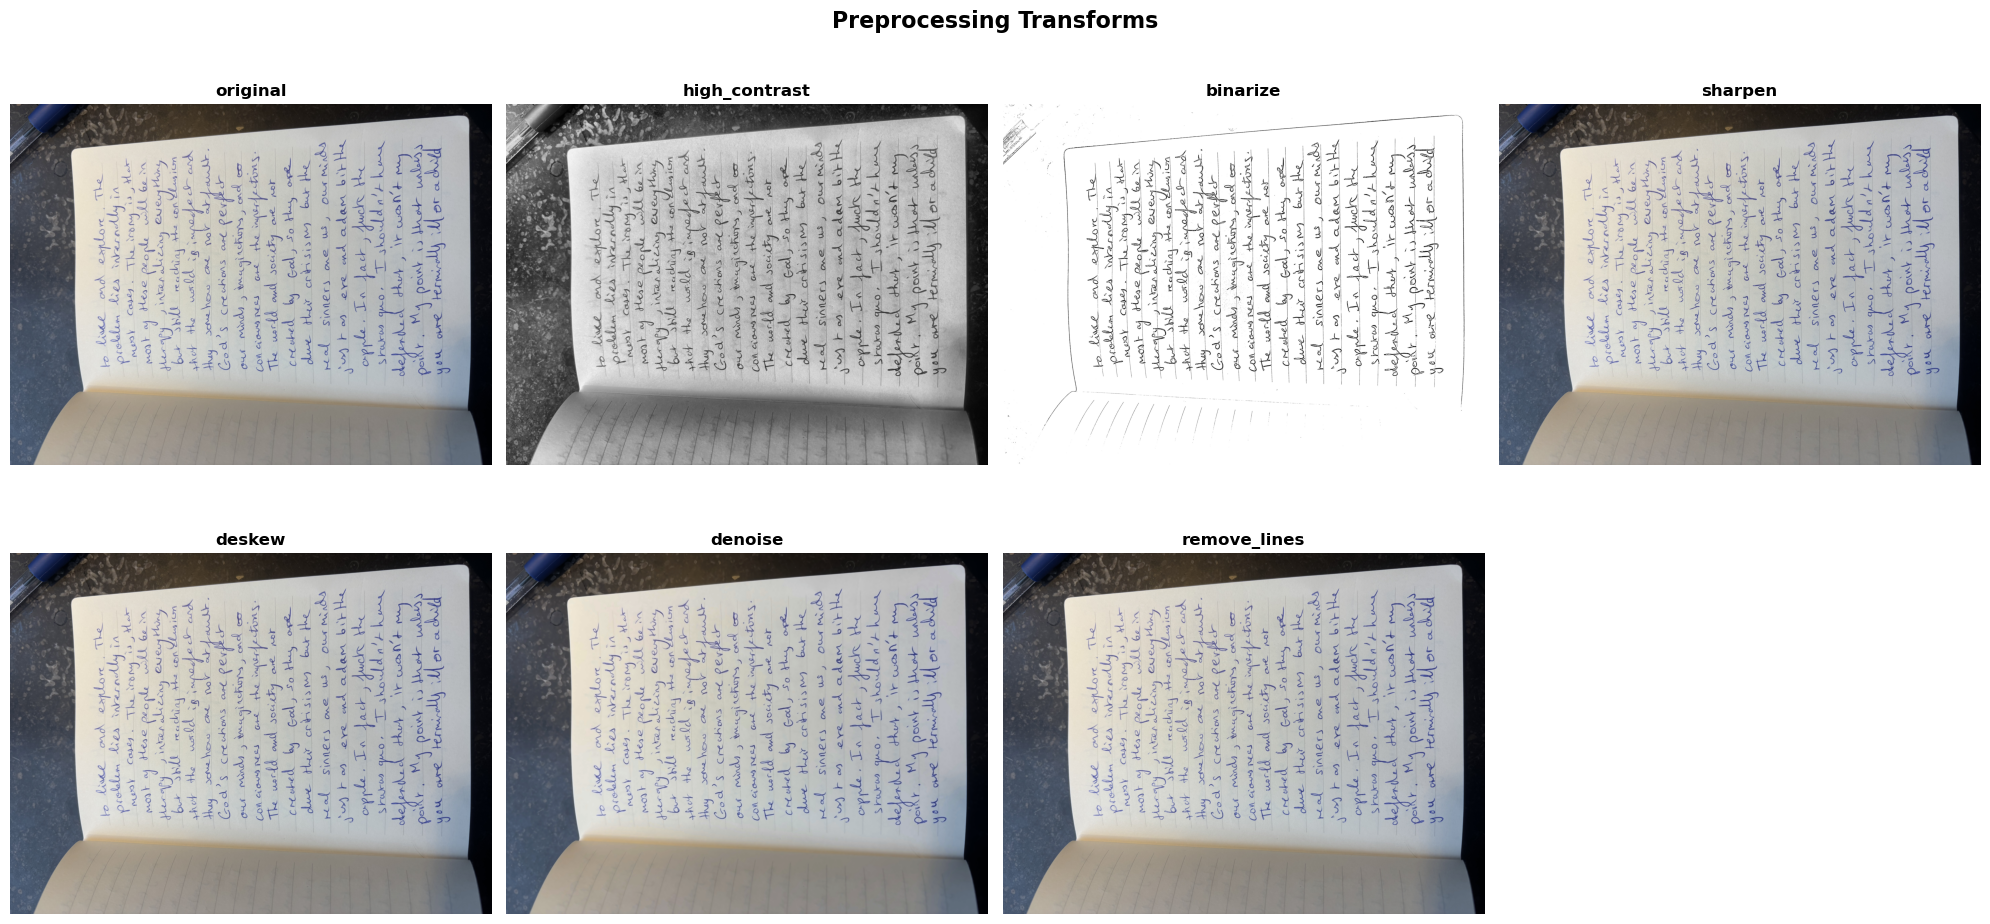

In [3]:
from ocr_agent.tools import (
    _apply_high_contrast, _apply_binarize, _apply_sharpen,
    _apply_deskew, _apply_denoise, _apply_remove_lines,
    preprocess_image,
)
from rag.ingest.index_images import make_random_crops, NUM_CROPS
import numpy as np
import random

# --- Pick a random image to preview ---
image_files = sorted(
    f for f in INPUT_DIR.iterdir()
    if f.suffix.lower() in (".jpg", ".jpeg", ".png")
)
preview_path = random.choice(image_files)
original = Image.open(preview_path).convert("RGB")
print(f"Previewing: {preview_path.name}  ({original.size[0]}x{original.size[1]})")

# --- Show all preprocessing transforms side by side ---
transforms = {
    "original": lambda img: img,
    "high_contrast": _apply_high_contrast,
    "binarize": _apply_binarize,
    "sharpen": _apply_sharpen,
    "deskew": _apply_deskew,
    "denoise": _apply_denoise,
    "remove_lines": _apply_remove_lines,
}

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for idx, (name, fn) in enumerate(transforms.items()):
    ax = axes[idx]
    result = fn(original)
    arr = np.array(result)
    is_grayscale = arr.ndim == 2 or (arr.ndim == 3 and arr.shape[2] == 1)
    ax.imshow(arr, cmap="gray" if is_grayscale else None)
    ax.set_title(name, fontsize=12, fontweight="bold")
    ax.axis("off")
axes[-1].axis("off")
axes[-1].set_visible(False)
fig.suptitle("Preprocessing Transforms", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

  [preprocess] Applying deskew+high_contrast+binarize...
Preprocessing: deskew → high_contrast → binarize
12 deterministic random crops



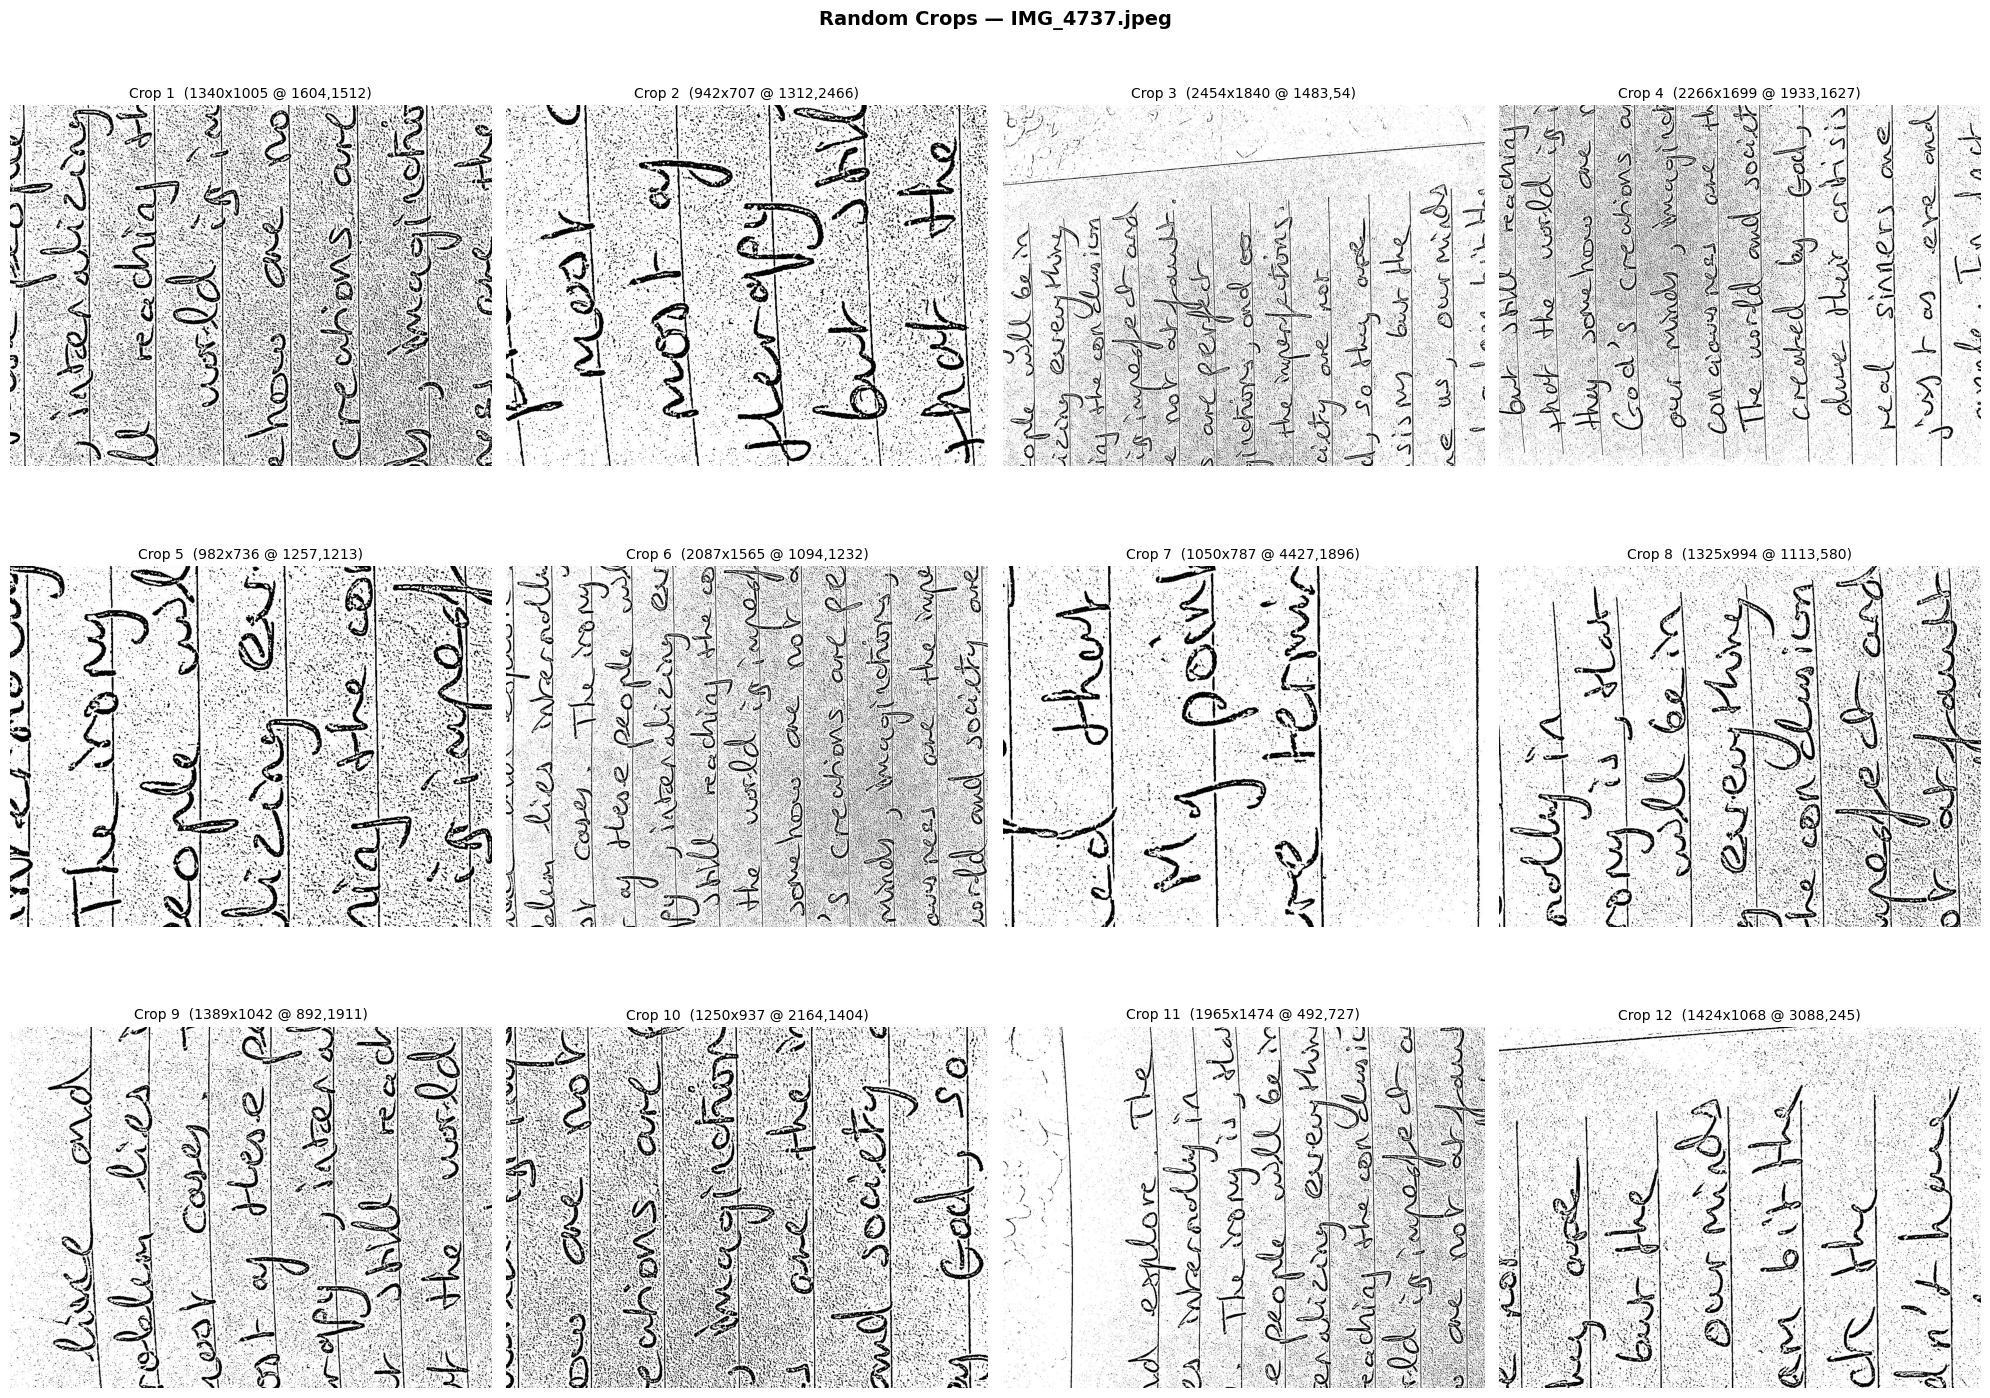

In [4]:
# --- Show the random crops that indexing will produce ---
processed_path = preprocess_image(str(preview_path), ["deskew", "high_contrast", "binarize"])
processed = Image.open(processed_path)

crops_preview = make_random_crops(processed, preview_path.stem, NUM_CROPS)
print(f"Preprocessing: deskew → high_contrast → binarize")
print(f"{len(crops_preview)} deterministic random crops\n")

cols = 4
rows = (len(crops_preview) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()
for idx, (crop_img, region) in enumerate(crops_preview):
    arr = np.array(crop_img)
    is_gray = arr.ndim == 2 or (arr.ndim == 3 and arr.shape[2] == 1)
    axes[idx].imshow(arr, cmap="gray" if is_gray else None)
    axes[idx].set_title(
        f"Crop {idx+1}  ({region['w']}x{region['h']} @ {region['x']},{region['y']})",
        fontsize=10,
    )
    axes[idx].axis("off")
for i in range(len(crops_preview), len(axes)):
    axes[i].set_visible(False)
fig.suptitle(f"Random Crops — {preview_path.name}", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## 4. Index — Preprocess, crop, and embed into Qdrant

Syncs images from S3 to local cache, then indexes each as horizontal strip crops with CLIP visual embeddings. No text — that comes from annotation.

In [4]:
from rag.ingest.index_images import index_all

# num_crops=0 indexes full images (default)
# num_crops=12 generates 12 random crops per image
total = index_all(sync_s3=True, num_crops=0)
print(f"\nIndexed {total} total points into Qdrant.")

2026-02-18 21:02:12.258 | INFO     | rag.storage.s3:list_images:118 - Found 18 images in s3://handwritten-ocr/
2026-02-18 21:02:12.263 | DEBUG    | rag.storage.s3:download_image:89 - Already cached: /Users/marwanbounassif/Documents/repos/handwritten-ocr/data/input/IMG_4737.jpeg
2026-02-18 21:02:12.263 | DEBUG    | rag.storage.s3:download_image:89 - Already cached: /Users/marwanbounassif/Documents/repos/handwritten-ocr/data/input/IMG_4836.HEIC
2026-02-18 21:02:12.264 | DEBUG    | rag.storage.s3:download_image:89 - Already cached: /Users/marwanbounassif/Documents/repos/handwritten-ocr/data/input/IMG_4837.HEIC
2026-02-18 21:02:12.265 | DEBUG    | rag.storage.s3:download_image:89 - Already cached: /Users/marwanbounassif/Documents/repos/handwritten-ocr/data/input/IMG_4838.HEIC
2026-02-18 21:02:12.266 | DEBUG    | rag.storage.s3:download_image:89 - Already cached: /Users/marwanbounassif/Documents/repos/handwritten-ocr/data/input/IMG_4839.HEIC
2026-02-18 21:02:12.266 | DEBUG    | rag.storage.

  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:02:12.707 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:02:14.762 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from IMG_4737.jpeg into 'handwritten_notes'


  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:02:16.985 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:02:19.631 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from IMG_4836.HEIC into 'handwritten_notes'


  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:02:21.923 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:02:24.246 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from IMG_4837.HEIC into 'handwritten_notes'


  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:02:26.480 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:02:29.037 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from IMG_4838.HEIC into 'handwritten_notes'


  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:02:31.285 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:02:33.846 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from IMG_4839.HEIC into 'handwritten_notes'


  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:02:36.112 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:02:38.586 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from IMG_4840.HEIC into 'handwritten_notes'


  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:02:40.826 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:02:43.439 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from IMG_4841.HEIC into 'handwritten_notes'


  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:02:45.690 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:02:48.156 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from IMG_4842.HEIC into 'handwritten_notes'


  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:02:50.425 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:02:53.044 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from IMG_4843.HEIC into 'handwritten_notes'


  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:02:55.323 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:02:57.748 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from IMG_4844.HEIC into 'handwritten_notes'


  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:03:00.038 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:03:02.732 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from IMG_4845.HEIC into 'handwritten_notes'


  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:03:05.014 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:03:07.538 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from IMG_4846.HEIC into 'handwritten_notes'


  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:03:09.754 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:03:12.270 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from IMG_4847.HEIC into 'handwritten_notes'


  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:03:14.529 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:03:17.239 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from IMG_4848.HEIC into 'handwritten_notes'


  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:03:19.504 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:03:22.237 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from IMG_4849.HEIC into 'handwritten_notes'


  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:03:24.542 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:03:27.139 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from IMG_4850.HEIC into 'handwritten_notes'


  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:03:29.409 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:03:32.142 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from IMG_4851.HEIC into 'handwritten_notes'


  [preprocess] Applying deskew+high_contrast+binarize...


2026-02-18 21:03:32.484 | INFO     | rag.schema:ensure_collection_exists:35 - Collection 'handwritten_notes' already exists — skipping creation.
2026-02-18 21:03:33.556 | INFO     | rag.ingest.index_images:index_image:190 - Indexed full image from test_notes.jpg into 'handwritten_notes'
2026-02-18 21:03:33.557 | INFO     | rag.ingest.index_images:index_all:237 - Done. Indexed 18 total points from 18 images.



Indexed 18 total points into Qdrant.


## 5. Annotate — Label crops with text and topic tags

Shows unannotated crops one at a time. For each:
- Type the text you see → Enter
- Type a topic tag → Enter (or Enter to skip)
- Enter with no text = skip crop
- Type `q` = stop annotating

In [8]:
def fetch_unannotated(limit: int = 30) -> list:
    """Fetch points with empty confirmed_text from Qdrant."""
    results = []
    offset = None
    while len(results) < limit:
        points, offset = client.scroll(
            collection_name=settings.COLLECTION_NAME,
            limit=min(100, limit - len(results)),
            offset=offset,
            with_payload=True,
            with_vectors=False,
        )
        for p in points:
            if not p.payload.get("confirmed_text", ""):
                results.append(p)
                if len(results) >= limit:
                    break
        if offset is None:
            break
    return results


def load_crop(source_image_id: str, region: dict) -> Image.Image | None:
    """Load source image and crop to region coords."""
    for ext in (".jpeg", ".jpg", ".png", ".tiff", ".bmp"):
        path = INPUT_DIR / f"{source_image_id}{ext}"
        if path.exists():
            img = Image.open(path).convert("RGB")
            x, y, w, h = region["x"], region["y"], region["w"], region["h"]
            return img.crop((x, y, x + w, y + h)), path
    return None


def load_crop_from_b64(b64: str) -> Image.Image:
    """Decode a base64 image crop."""
    return Image.open(io.BytesIO(base64.b64decode(b64))).convert("RGB")


def display_crop(crop: Image.Image, idx: int, total: int, path):
    """Show original and enhanced crop side by side."""
    enhanced = preprocess_image(str(path), ["deskew", "high_contrast", "binarize"])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    ax1.imshow(crop)
    ax1.set_title(f"Original  [{idx+1}/{total}]")
    ax1.axis("off")
    ax2.imshow(enhanced, cmap="gray")
    ax2.set_title(f"Enhanced  [{idx+1}/{total}]")
    ax2.axis("off")
    plt.tight_layout()
    plt.show()


def update_annotation(point_id: str, text: str, topic_tag: str, chunk_type: str):
    """Update a Qdrant point with text embeddings and annotation metadata."""
    dense_vecs = embed_dense([text])
    sparse_vecs = embed_sparse([text])

    client.set_payload(
        collection_name=settings.COLLECTION_NAME,
        payload={
            "confirmed_text": text,
            "raw_ocr_text": text,
            "confidence_score": 1.0,
            "from_human_review": True,
            "chunk_type": chunk_type,
            "topic_tags": [topic_tag] if topic_tag else [],
            "annotated_at": datetime.now(timezone.utc).isoformat(),
        },
        points=[point_id],
    )

    client.update_vectors(
        collection_name=settings.COLLECTION_NAME,
        points=[
            {
                "id": point_id,
                "vector": {
                    "text_dense": dense_vecs[0],
                    "text_sparse": sparse_vecs[0],
                },
            }
        ],
    )
    return point_id


print("Helpers loaded.")

Helpers loaded.


Found 2 unannotated crops.



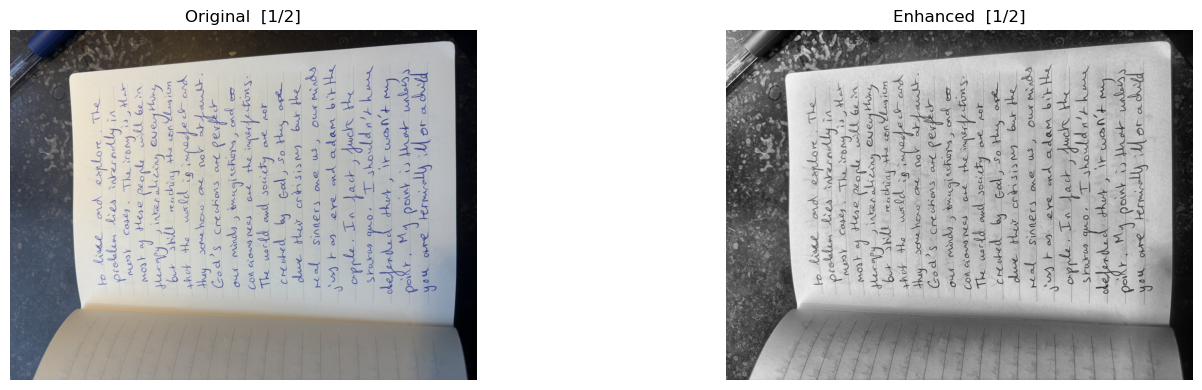

  Source: IMG_4737  Region: y=0, h=4284


2026-02-18 20:27:29.532 | INFO     | rag.embeddings.bge_embedder:_get_dense_model:25 - Loading BGE-large-en-v1.5 dense model (first call — ~1.2GB)...
2026-02-18 20:27:30.043 | INFO     | rag.embeddings.bge_embedder:_get_dense_model:27 - BGE dense model loaded.
2026-02-18 20:27:30.159 | INFO     | rag.embeddings.bge_embedder:_get_sparse_model:37 - Loading BGE-M3 sparse model (first call)...
2026-02-18 20:27:30.218 | INFO     | rag.embeddings.bge_embedder:_get_sparse_model:39 - BGE-M3 sparse model loaded.


  Annotated: cec051ac-2fd9-5097-a692-e43e9055e3c3 (sentence)



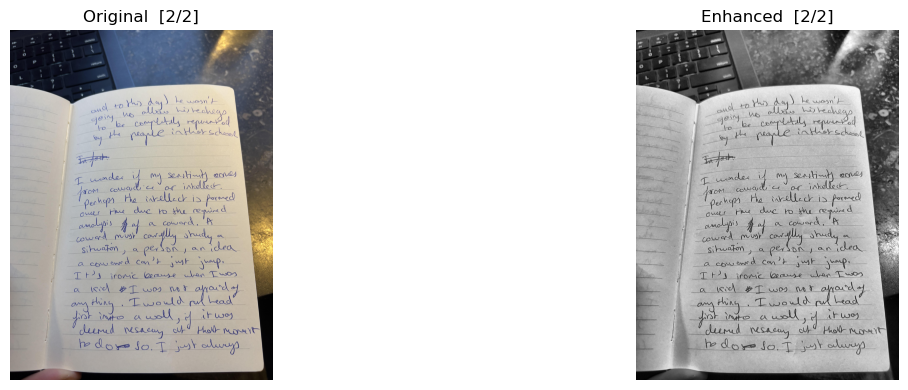

  Source: test_notes  Region: y=0, h=5712
  Annotated: ffbda985-ea7d-5466-97e0-14f5760c87de (sentence)


Done. Annotated 2 crops.


In [ ]:
crops = fetch_unannotated(limit=30)
print(f"Found {len(crops)} unannotated crops.\n")

annotated_count = 0

for idx, point in enumerate(crops):
    payload = point.payload
    source_id = payload.get("source_image_id", "?")
    region = payload.get("region_coords", {})

    crop_img, path = load_crop(source_id, region)
    if crop_img is None:
        b64 = payload.get("image_crop_base64", "")
        if b64:
            crop_img = load_crop_from_b64(b64)
        else:
            print(f"  [{idx+1}/{len(crops)}] Cannot load crop for {source_id}, skipping.")
            continue

    display_crop(crop_img, idx, len(crops), path)
    print(f"  Source: {source_id}  Region: y={region.get('y')}, h={region.get('h')}")

    text = input(f"  [{idx+1}/{len(crops)}] Text (Enter=skip, q=stop): ").strip()
    if text.lower() == "q":
        print("Stopping.")
        break
    if not text:
        print("  Skipped.")
        continue

    tag = input("  Topic tag (Enter=skip): ").strip()

    wc = len(text.split())
    chunk_type = "word" if wc <= 2 else ("phrase" if wc <= 6 else "sentence")

    pid = update_annotation(point.id, text, tag, chunk_type)
    annotated_count += 1
    print(f"  Annotated: {pid} ({chunk_type})\n")

print(f"\nDone. Annotated {annotated_count} crops.")